##Functions

In [ ]:
def splitTrainTestSet(X, y, testRatio, randomState=345):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=randomState,
                                                        stratify=y)
    return X_train, X_test, y_train, y_test

In [ ]:
def applySPCA(X, numComponents):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = SparsePCA(n_components=numComponents)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, pca

In [ ]:
def applyMRMR(X,y,K):
    from mrmr import mrmr_classif

    X_q = X.reshape(np.prod(X.shape[:2]),np.prod(X.shape[2:]))
    y_q = y.reshape(np.prod(y.shape[:2]))

    X = pd.DataFrame(X_q)
    y = pd.Series(y_q)

    newX = np.reshape(X, (-1, X.shape[1]))
    selected_features = mrmr_classif(newX, y, K)

    X = X[:,:,selected_features]

    return X

In [ ]:
def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

In [ ]:
def createImageCubes(X, y, windowSize=25, removeZeroLabels = True):
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels

In [ ]:
loc_1 = "/content/drive/MyDrive/Colab Notebooks/Paper 05/"
loc_2 = "06_SPCA_3D_2D_CNN_"

dataset = 'SA'
test_ratio = 0.9
windowSize = 25

ratio_per = 100-int(test_ratio*100)
ratio_per = str(ratio_per)+'%'
ratio_per

'10%'

In [ ]:
X, y = loadData(dataset)

X.shape, y.shape

((512, 217, 204), (512, 217))

In [ ]:
# Visualize original data
K = X.shape[2]
X_vis = X.reshape(np.prod(X.shape[:2]),np.prod(X.shape[2:]))
df = pd.DataFrame(X_vis,columns=(list(range(1,K+1))))
df

,1,2,3,4,5,6,7,8,9,10,...,195,196,197,198,199,200,201,202,203,204
0,290,381,585,1041,1316,1397,1319,1462,1643,1683,...,104,96,109,93,54,79,54,36,11,17
1,290,381,519,1041,1316,1352,1319,1462,1643,1683,...,111,94,111,96,56,83,56,36,11,15
2,290,381,585,1041,1286,1352,1300,1412,1614,1644,...,106,88,107,89,54,81,54,30,11,11
3,290,381,585,999,1316,1374,1280,1380,1584,1631,...,100,86,105,85,56,75,50,30,11,19
4,219,381,585,999,1286,1352,1261,1396,1555,1618,...,96,83,105,83,48,75,50,24,9,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111099,376,405,608,1043,1382,1446,1376,1526,1719,1760,...,141,121,150,124,72,112,76,46,17,27
111100,305,489,608,1086,1353,1446,1357,1510,1704,1760,...,138,126,144,122,76,106,74,40,13,21
111101,447,405,674,1128,1382,1446,1357,1493,1690,1760,...,141,117,146,120,72,108,76,42,11,23
111102,447,405,674,1086,1382,1424,1357,1493,1704,1734,...,136,123,144,122,80,110,78,42,17,27


##Apply SPCA

In [ ]:
# K = 10 if dataset == 'IP' else 5
K = X.shape[2]
X,pca = applySPCA(X,numComponents=K)

X.shape

(512, 217, 204)

In [ ]:
K = 10 if dataset == 'IP' else 5
X = applyMRMR(X,y,K)
X.shape


(512, 217, 5)

In [ ]:
X, y = createImageCubes(X, y, windowSize=windowSize)

X.shape, y.shape

((54129, 25, 25, 5), (54129,))

In [ ]:
Xtrain, Xtest, ytrain, ytest = splitTrainTestSet(X, y, test_ratio)

Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape

((5412, 25, 25, 5), (48717, 25, 25, 5), (5412,), (48717,))

Xtrain, Xvalid, ytrain, yvalid = splitTrainTestSet(Xtrain, ytrain, 0.3333)

Xtrain.shape, Xvalid.shape, ytrain.shape, yvalid.shape

# Model and Training

In [ ]:
Xtrain = Xtrain.reshape(-1, windowSize, windowSize, K, 1)
Xtrain.shape

(5412, 25, 25, 5, 1)

In [ ]:
ytrain = np_utils.to_categorical(ytrain)
ytest = np_utils.to_categorical(ytest)
ytrain.shape, ytest.shape

((5412, 16), (48717, 16))

Xvalid = Xvalid.reshape(-1, windowSize, windowSize, K, 1)
Xvalid.shape

yvalid = np_utils.to_categorical(yvalid)
yvalid.shape

In [ ]:
S = windowSize
L = K
# output_units = 9 if (dataset == 'PU' or dataset == 'PC') else 16
output_units = ytrain.shape[1]

In [ ]:


input_shape = (15, 15, L, 1)
output_units = 14

input_layer = Input(shape=input_shape)

# First branch
conv_layer1_1 = Conv3D(filters=8, kernel_size=(3, 3, 3), activation='relu')(input_layer)
norm_1_1 = BatchNormalization()(conv_layer1_1)

conv_layer1_2 = Conv3D(filters=16, kernel_size=(3, 3, 1), activation='relu', kernel_regularizer=l2(0.0001))(norm_1_1)
norm_1_2 = BatchNormalization()(conv_layer1_2)

# Second Branch
conv_layer2_1 = Conv3D(filters=8, kernel_size=(3, 3, 3), activation='relu')(input_layer)
norm_2_1 = BatchNormalization()(conv_layer2_1)

conv_layer2_2 = Conv3D(filters=16, kernel_size=(3, 3, 1), activation='relu', kernel_regularizer=l2(0.0001))(norm_2_1)
norm_2_2 = BatchNormalization()(conv_layer2_2)


concat = concatenate([norm_1_2, norm_2_2])

conv3d_shape = concat.shape
conv_layer___ = Reshape((conv3d_shape[1], conv3d_shape[2], conv3d_shape[3]*conv3d_shape[4]))(concat)

conv_layer5 = DepthwiseConv2D(kernel_size=(3, 3), activation='relu')(conv_layer___)
norm_5 = BatchNormalization()(conv_layer5)

flatten_layer = Flatten()(norm_5)

dense_layer1 = Dense(units=256, activation='relu')(flatten_layer)
dense_layer1 = Dropout(0.4)(dense_layer1)

dense_layer2 = Dense(units=128, activation='relu')(dense_layer1)
dense_layer2 = Dropout(0.5)(dense_layer2)

output_layer = Dense(units=output_units, activation='softmax')(dense_layer2)

model = Model(inputs=input_layer, outputs=output_layer)


In [ ]:
# define the model with input layer and output layer
model = Model(inputs=input_layer, outputs=output_layer)

# model_arch = f'{loc_1}figure/{ratio_per}/{dataset}/{loc_2}architech{dataset}.png'
# plot_model(model, to_file=model_arch)

model.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 15, 15, 5, 1)]       0         []                            
                                                                                                  
 conv3d_14 (Conv3D)          (None, 13, 13, 3, 8)         224       ['input_5[0][0]']             
                                                                                                  
 conv3d_16 (Conv3D)          (None, 13, 13, 3, 8)         224       ['input_5[0][0]']             
                                                                                                  
 batch_normalization_20 (Ba  (None, 13, 13, 3, 8)         32        ['conv3d_14[0][0]']           
 tchNormalization)                                                                          

In [ ]:
# compiling the model
adam = Adam(learning_rate=0.001, decay=1e-06)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [ ]:
# checkpoint
filepath = "/content/drive/MyDrive/Colab Notebooks/Paper 05/saved_model/default_model.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [ ]:
history = model.fit(x=Xtrain, y=ytrain, batch_size=256, epochs=120, callbacks=callbacks_list)

Epoch 1/120
43/43 [==============================] - ETA: 0s - loss: 0.9420 - accuracy: 0.7774

43/43 [==============================] - 19s 44ms/step - loss: 0.9420 - accuracy: 0.7774
Epoch 2/120
41/43 [===========================>..] - ETA: 0s - loss: 0.2011 - accuracy: 0.9350

43/43 [==============================] - 2s 40ms/step - loss: 0.2002 - accuracy: 0.9355
Epoch 3/120
43/43 [==============================] - ETA: 0s - loss: 0.0939 - accuracy: 0.9692

43/43 [==============================] - 2s 35ms/step - loss: 0.0939 - accuracy: 0.9692
Epoch 4/120
41/43 [===========================>..] - ETA: 0s - loss: 0.0487 - accuracy: 0.9847

43/43 [==============================] - 2s 35ms/step - loss: 0.0491 - accuracy: 0.9846
Epoch 5/120
43/43 [==============================] - ETA: 0s - loss: 0.0448 - accuracy: 0.9870

43/43 [==============================] - 2s 35ms/step - loss: 0.0448 - accuracy: 0.9870
Epoch 6/120
41/43 [===========================>..] - ETA: 0s - loss: 0.0391 - accuracy: 0.9880

43/43 [==============================] - 2s 35ms/step - loss: 0.0398 - accuracy: 0.9879
Epoch 7/120
43/43 [==============================] - ETA: 0s - loss: 0.0472 - accuracy: 0.9873

43/43 [==============================] - 2s 35ms/step - loss: 0.0472 - accuracy: 0.9873
Epoch 8/120
43/43 [==============================] - ETA: 0s - loss: 0.0338 - accuracy: 0.9902

43/43 [==============================] - 2s 35ms/step - loss: 0.0338 - accuracy: 0.9902
Epoch 9/120
43/43 [==============================] - ETA: 0s - loss: 0.0227 - accuracy: 0.9955

43/43 [==============================] - 2s 35ms/step - loss: 0.0227 - accuracy: 0.9955
Epoch 10/120
43/43 [==============================] - ETA: 0s - loss: 0.0825 - accuracy: 0.9805

43/43 [==============================] - 2s 35ms/step - loss: 0.0825 - accuracy: 0.9805
Epoch 11/120
41/43 [===========================>..] - ETA: 0s - loss: 0.0590 - accuracy: 0.9844

43/43 [==============================] - 2s 35ms/step - loss: 0.0598 - accuracy: 0.9844
Epoch 12/120
43/43 [==============================] - ETA: 0s - loss: 0.0199 - accuracy: 0.9954

43/43 [==============================] - 2s 36ms/step - loss: 0.0199 - accuracy: 0.9954
Epoch 13/120
42/43 [============================>.] - ETA: 0s - loss: 0.0130 - accuracy: 0.9963

43/43 [==============================] - 2s 40ms/step - loss: 0.0129 - accuracy: 0.9963
Epoch 14/120
42/43 [============================>.] - ETA: 0s - loss: 0.0240 - accuracy: 0.9952

43/43 [==============================] - 2s 42ms/step - loss: 0.0239 - accuracy: 0.9952
Epoch 15/120
42/43 [============================>.] - ETA: 0s - loss: 0.0247 - accuracy: 0.9925

43/43 [==============================] - 2s 41ms/step - loss: 0.0245 - accuracy: 0.9925
Epoch 16/120
42/43 [============================>.] - ETA: 0s - loss: 0.0154 - accuracy: 0.9960

43/43 [==============================] - 2s 41ms/step - loss: 0.0153 - accuracy: 0.9960
Epoch 17/120
42/43 [============================>.] - ETA: 0s - loss: 0.0066 - accuracy: 0.9984

43/43 [==============================] - 2s 39ms/step - loss: 0.0066 - accuracy: 0.9984
Epoch 18/120
43/43 [==============================] - ETA: 0s - loss: 0.0024 - accuracy: 0.9993

43/43 [==============================] - 2s 41ms/step - loss: 0.0024 - accuracy: 0.9993
Epoch 19/120
42/43 [============================>.] - ETA: 0s - loss: 0.0066 - accuracy: 0.9991

43/43 [==============================] - 2s 39ms/step - loss: 0.0066 - accuracy: 0.9991
Epoch 20/120
43/43 [==============================] - ETA: 0s - loss: 0.0076 - accuracy: 0.9983

43/43 [==============================] - 2s 35ms/step - loss: 0.0076 - accuracy: 0.9983
Epoch 21/120
41/43 [===========================>..] - ETA: 0s - loss: 0.0056 - accuracy: 0.9985

43/43 [==============================] - 2s 35ms/step - loss: 0.0055 - accuracy: 0.9985
Epoch 22/120
41/43 [===========================>..] - ETA: 0s - loss: 0.0438 - accuracy: 0.9879

43/43 [==============================] - 2s 36ms/step - loss: 0.0434 - accuracy: 0.9881
Epoch 23/120
43/43 [==============================] - ETA: 0s - loss: 0.0108 - accuracy: 0.9972

43/43 [==============================] - 2s 35ms/step - loss: 0.0108 - accuracy: 0.9972
Epoch 24/120
43/43 [==============================] - ETA: 0s - loss: 0.0325 - accuracy: 0.9933

43/43 [==============================] - 2s 36ms/step - loss: 0.0325 - accuracy: 0.9933
Epoch 25/120
43/43 [==============================] - ETA: 0s - loss: 0.1019 - accuracy: 0.9724

43/43 [==============================] - 2s 36ms/step - loss: 0.1019 - accuracy: 0.9724
Epoch 26/120
43/43 [==============================] - ETA: 0s - loss: 0.0586 - accuracy: 0.9853

43/43 [==============================] - 2s 36ms/step - loss: 0.0586 - accuracy: 0.9853
Epoch 27/120
43/43 [==============================] - ETA: 0s - loss: 0.0612 - accuracy: 0.9864

43/43 [==============================] - 2s 36ms/step - loss: 0.0612 - accuracy: 0.9864
Epoch 28/120
43/43 [==============================] - ETA: 0s - loss: 0.0562 - accuracy: 0.9885

43/43 [==============================] - 2s 36ms/step - loss: 0.0562 - accuracy: 0.9885
Epoch 29/120
43/43 [==============================] - ETA: 0s - loss: 0.0258 - accuracy: 0.9959

43/43 [==============================] - 2s 36ms/step - loss: 0.0258 - accuracy: 0.9959
Epoch 30/120
41/43 [===========================>..] - ETA: 0s - loss: 0.1564 - accuracy: 0.9787

43/43 [==============================] - 2s 36ms/step - loss: 0.1535 - accuracy: 0.9787
Epoch 31/120
43/43 [==============================] - ETA: 0s - loss: 0.0367 - accuracy: 0.9923

43/43 [==============================] - 2s 36ms/step - loss: 0.0367 - accuracy: 0.9923
Epoch 32/120
43/43 [==============================] - ETA: 0s - loss: 0.0203 - accuracy: 0.9951

43/43 [==============================] - 2s 36ms/step - loss: 0.0203 - accuracy: 0.9951
Epoch 33/120
41/43 [===========================>..] - ETA: 0s - loss: 0.0105 - accuracy: 0.9976

43/43 [==============================] - 2s 36ms/step - loss: 0.0102 - accuracy: 0.9977
Epoch 34/120
43/43 [==============================] - ETA: 0s - loss: 0.0095 - accuracy: 0.9975

43/43 [==============================] - 2s 36ms/step - loss: 0.0095 - accuracy: 0.9975
Epoch 35/120
41/43 [===========================>..] - ETA: 0s - loss: 0.0060 - accuracy: 0.9983

43/43 [==============================] - 2s 36ms/step - loss: 0.0058 - accuracy: 0.9983
Epoch 36/120
43/43 [==============================] - ETA: 0s - loss: 0.0047 - accuracy: 0.9991

43/43 [==============================] - 2s 38ms/step - loss: 0.0047 - accuracy: 0.9991
Epoch 37/120
42/43 [============================>.] - ETA: 0s - loss: 0.0034 - accuracy: 0.9992

43/43 [==============================] - 2s 39ms/step - loss: 0.0035 - accuracy: 0.9991
Epoch 38/120
43/43 [==============================] - ETA: 0s - loss: 0.0048 - accuracy: 0.9994

43/43 [==============================] - 2s 36ms/step - loss: 0.0048 - accuracy: 0.9994
Epoch 39/120
43/43 [==============================] - ETA: 0s - loss: 0.0065 - accuracy: 0.9984

43/43 [==============================] - 2s 36ms/step - loss: 0.0065 - accuracy: 0.9984
Epoch 40/120
43/43 [==============================] - ETA: 0s - loss: 0.0101 - accuracy: 0.9978

43/43 [==============================] - 2s 36ms/step - loss: 0.0101 - accuracy: 0.9978
Epoch 41/120
43/43 [==============================] - ETA: 0s - loss: 0.0124 - accuracy: 0.9967

43/43 [==============================] - 2s 36ms/step - loss: 0.0124 - accuracy: 0.9967
Epoch 42/120
43/43 [==============================] - ETA: 0s - loss: 0.0123 - accuracy: 0.9966

43/43 [==============================] - 2s 36ms/step - loss: 0.0123 - accuracy: 0.9966
Epoch 43/120
43/43 [==============================] - ETA: 0s - loss: 0.0538 - accuracy: 0.9925

43/43 [==============================] - 2s 36ms/step - loss: 0.0538 - accuracy: 0.9925
Epoch 44/120
43/43 [==============================] - ETA: 0s - loss: 0.0085 - accuracy: 0.9974

43/43 [==============================] - 2s 36ms/step - loss: 0.0085 - accuracy: 0.9974
Epoch 45/120
43/43 [==============================] - ETA: 0s - loss: 0.0060 - accuracy: 0.9984

43/43 [==============================] - 2s 36ms/step - loss: 0.0060 - accuracy: 0.9984
Epoch 46/120
43/43 [==============================] - ETA: 0s - loss: 0.0024 - accuracy: 0.9992

43/43 [==============================] - 2s 36ms/step - loss: 0.0024 - accuracy: 0.9992
Epoch 47/120
43/43 [==============================] - ETA: 0s - loss: 0.0026 - accuracy: 0.9992

43/43 [==============================] - 2s 37ms/step - loss: 0.0026 - accuracy: 0.9992
Epoch 48/120
43/43 [==============================] - ETA: 0s - loss: 0.0048 - accuracy: 0.9989

43/43 [==============================] - 2s 37ms/step - loss: 0.0048 - accuracy: 0.9989
Epoch 49/120
43/43 [==============================] - ETA: 0s - loss: 0.0112 - accuracy: 0.9973

43/43 [==============================] - 2s 37ms/step - loss: 0.0112 - accuracy: 0.9973
Epoch 50/120
43/43 [==============================] - ETA: 0s - loss: 0.0116 - accuracy: 0.9980

43/43 [==============================] - 2s 36ms/step - loss: 0.0116 - accuracy: 0.9980
Epoch 51/120
43/43 [==============================] - ETA: 0s - loss: 0.0101 - accuracy: 0.9978

43/43 [==============================] - 2s 36ms/step - loss: 0.0101 - accuracy: 0.9978
Epoch 52/120
43/43 [==============================] - ETA: 0s - loss: 0.0075 - accuracy: 0.9985

43/43 [==============================] - 2s 37ms/step - loss: 0.0075 - accuracy: 0.9985
Epoch 53/120
43/43 [==============================] - ETA: 0s - loss: 0.0217 - accuracy: 0.9983

43/43 [==============================] - 2s 37ms/step - loss: 0.0217 - accuracy: 0.9983
Epoch 54/120
43/43 [==============================] - ETA: 0s - loss: 0.0053 - accuracy: 0.9987

43/43 [==============================] - 2s 42ms/step - loss: 0.0053 - accuracy: 0.9987
Epoch 55/120
43/43 [==============================] - ETA: 0s - loss: 0.0158 - accuracy: 0.9979

43/43 [==============================] - 2s 42ms/step - loss: 0.0158 - accuracy: 0.9979
Epoch 56/120
43/43 [==============================] - ETA: 0s - loss: 0.0238 - accuracy: 0.9984

43/43 [==============================] - 2s 37ms/step - loss: 0.0238 - accuracy: 0.9984
Epoch 57/120
43/43 [==============================] - ETA: 0s - loss: 0.0191 - accuracy: 0.9964

43/43 [==============================] - 2s 37ms/step - loss: 0.0191 - accuracy: 0.9964
Epoch 58/120
43/43 [==============================] - ETA: 0s - loss: 0.0053 - accuracy: 0.9990

43/43 [==============================] - 2s 37ms/step - loss: 0.0053 - accuracy: 0.9990
Epoch 59/120
43/43 [==============================] - ETA: 0s - loss: 0.0085 - accuracy: 0.9991

43/43 [==============================] - 2s 37ms/step - loss: 0.0085 - accuracy: 0.9991
Epoch 60/120
43/43 [==============================] - ETA: 0s - loss: 0.0192 - accuracy: 0.9960

43/43 [==============================] - 2s 37ms/step - loss: 0.0192 - accuracy: 0.9960
Epoch 61/120
43/43 [==============================] - ETA: 0s - loss: 0.0132 - accuracy: 0.9978

43/43 [==============================] - 2s 37ms/step - loss: 0.0132 - accuracy: 0.9978
Epoch 62/120
43/43 [==============================] - ETA: 0s - loss: 0.0132 - accuracy: 0.9983

43/43 [==============================] - 2s 39ms/step - loss: 0.0132 - accuracy: 0.9983
Epoch 63/120
42/43 [============================>.] - ETA: 0s - loss: 0.0039 - accuracy: 0.9988

43/43 [==============================] - 2s 41ms/step - loss: 0.0039 - accuracy: 0.9988
Epoch 64/120
43/43 [==============================] - ETA: 0s - loss: 0.0034 - accuracy: 0.9987

43/43 [==============================] - 2s 37ms/step - loss: 0.0034 - accuracy: 0.9987
Epoch 65/120
43/43 [==============================] - ETA: 0s - loss: 0.0053 - accuracy: 0.9988

43/43 [==============================] - 2s 37ms/step - loss: 0.0053 - accuracy: 0.9988
Epoch 66/120
42/43 [============================>.] - ETA: 0s - loss: 0.0037 - accuracy: 0.9989

43/43 [==============================] - 2s 42ms/step - loss: 0.0037 - accuracy: 0.9989
Epoch 67/120
42/43 [============================>.] - ETA: 0s - loss: 0.0100 - accuracy: 0.9985

43/43 [==============================] - 2s 38ms/step - loss: 0.0099 - accuracy: 0.9985
Epoch 68/120
43/43 [==============================] - ETA: 0s - loss: 0.0075 - accuracy: 0.9992

43/43 [==============================] - 2s 37ms/step - loss: 0.0075 - accuracy: 0.9992
Epoch 69/120
43/43 [==============================] - ETA: 0s - loss: 0.0055 - accuracy: 0.9988

43/43 [==============================] - 2s 37ms/step - loss: 0.0055 - accuracy: 0.9988
Epoch 70/120
43/43 [==============================] - ETA: 0s - loss: 9.8385e-04 - accuracy: 0.9997

43/43 [==============================] - 2s 37ms/step - loss: 9.8385e-04 - accuracy: 0.9997
Epoch 71/120
43/43 [==============================] - ETA: 0s - loss: 6.0855e-04 - accuracy: 0.9999

43/43 [==============================] - 2s 37ms/step - loss: 6.0855e-04 - accuracy: 0.9999
Epoch 72/120
43/43 [==============================] - ETA: 0s - loss: 3.4119e-04 - accuracy: 0.9998

43/43 [==============================] - 2s 40ms/step - loss: 3.4119e-04 - accuracy: 0.9998
Epoch 73/120
43/43 [==============================] - ETA: 0s - loss: 2.3281e-04 - accuracy: 0.9999

43/43 [==============================] - 2s 37ms/step - loss: 2.3281e-04 - accuracy: 0.9999
Epoch 74/120
43/43 [==============================] - ETA: 0s - loss: 1.4955e-04 - accuracy: 1.0000

43/43 [==============================] - 2s 37ms/step - loss: 1.4955e-04 - accuracy: 1.0000
Epoch 75/120
43/43 [==============================] - ETA: 0s - loss: 8.0324e-04 - accuracy: 0.9996

43/43 [==============================] - 2s 37ms/step - loss: 8.0324e-04 - accuracy: 0.9996
Epoch 76/120
43/43 [==============================] - ETA: 0s - loss: 0.0291 - accuracy: 0.9992

43/43 [==============================] - 2s 37ms/step - loss: 0.0291 - accuracy: 0.9992
Epoch 77/120
43/43 [==============================] - ETA: 0s - loss: 0.0107 - accuracy: 0.9984

43/43 [==============================] - 2s 40ms/step - loss: 0.0107 - accuracy: 0.9984
Epoch 78/120
43/43 [==============================] - ETA: 0s - loss: 0.0484 - accuracy: 0.9916

43/43 [==============================] - 2s 37ms/step - loss: 0.0484 - accuracy: 0.9916
Epoch 79/120
41/43 [===========================>..] - ETA: 0s - loss: 0.0048 - accuracy: 0.9993

43/43 [==============================] - 2s 37ms/step - loss: 0.0061 - accuracy: 0.9992
Epoch 80/120
43/43 [==============================] - ETA: 0s - loss: 0.0329 - accuracy: 0.9944

43/43 [==============================] - 2s 37ms/step - loss: 0.0329 - accuracy: 0.9944
Epoch 81/120
43/43 [==============================] - ETA: 0s - loss: 0.0366 - accuracy: 0.9933

43/43 [==============================] - 2s 37ms/step - loss: 0.0366 - accuracy: 0.9933
Epoch 82/120
43/43 [==============================] - ETA: 0s - loss: 0.0073 - accuracy: 0.9982

43/43 [==============================] - 2s 37ms/step - loss: 0.0073 - accuracy: 0.9982
Epoch 83/120
43/43 [==============================] - ETA: 0s - loss: 0.0057 - accuracy: 0.9991

43/43 [==============================] - 2s 36ms/step - loss: 0.0057 - accuracy: 0.9991
Epoch 84/120
43/43 [==============================] - ETA: 0s - loss: 0.0301 - accuracy: 0.9955

43/43 [==============================] - 2s 37ms/step - loss: 0.0301 - accuracy: 0.9955
Epoch 85/120
43/43 [==============================] - ETA: 0s - loss: 0.0120 - accuracy: 0.9970

43/43 [==============================] - 2s 37ms/step - loss: 0.0120 - accuracy: 0.9970
Epoch 86/120
43/43 [==============================] - ETA: 0s - loss: 0.0098 - accuracy: 0.9987

43/43 [==============================] - 2s 37ms/step - loss: 0.0098 - accuracy: 0.9987
Epoch 87/120
43/43 [==============================] - ETA: 0s - loss: 0.0195 - accuracy: 0.9956

43/43 [==============================] - 2s 37ms/step - loss: 0.0195 - accuracy: 0.9956
Epoch 88/120
43/43 [==============================] - ETA: 0s - loss: 0.0082 - accuracy: 0.9978

43/43 [==============================] - 2s 36ms/step - loss: 0.0082 - accuracy: 0.9978
Epoch 89/120
43/43 [==============================] - ETA: 0s - loss: 0.0023 - accuracy: 0.9992

43/43 [==============================] - 2s 37ms/step - loss: 0.0023 - accuracy: 0.9992
Epoch 90/120
43/43 [==============================] - ETA: 0s - loss: 0.0219 - accuracy: 0.9982

43/43 [==============================] - 2s 37ms/step - loss: 0.0219 - accuracy: 0.9982
Epoch 91/120
43/43 [==============================] - ETA: 0s - loss: 0.0407 - accuracy: 0.9927

43/43 [==============================] - 2s 38ms/step - loss: 0.0407 - accuracy: 0.9927
Epoch 92/120
43/43 [==============================] - ETA: 0s - loss: 0.0255 - accuracy: 0.9958

43/43 [==============================] - 2s 37ms/step - loss: 0.0255 - accuracy: 0.9958
Epoch 93/120
43/43 [==============================] - ETA: 0s - loss: 0.0288 - accuracy: 0.9945

43/43 [==============================] - 2s 36ms/step - loss: 0.0288 - accuracy: 0.9945
Epoch 94/120
43/43 [==============================] - ETA: 0s - loss: 0.0144 - accuracy: 0.9980

43/43 [==============================] - 2s 37ms/step - loss: 0.0144 - accuracy: 0.9980
Epoch 95/120
42/43 [============================>.] - ETA: 0s - loss: 0.0083 - accuracy: 0.9985

43/43 [==============================] - 2s 38ms/step - loss: 0.0094 - accuracy: 0.9983
Epoch 96/120
43/43 [==============================] - ETA: 0s - loss: 0.0265 - accuracy: 0.9965

43/43 [==============================] - 2s 37ms/step - loss: 0.0265 - accuracy: 0.9965
Epoch 97/120
43/43 [==============================] - ETA: 0s - loss: 0.0053 - accuracy: 0.9989

43/43 [==============================] - 2s 41ms/step - loss: 0.0053 - accuracy: 0.9989
Epoch 98/120
43/43 [==============================] - ETA: 0s - loss: 0.0072 - accuracy: 0.9985

43/43 [==============================] - 2s 37ms/step - loss: 0.0072 - accuracy: 0.9985
Epoch 99/120
43/43 [==============================] - ETA: 0s - loss: 0.0149 - accuracy: 0.9983

43/43 [==============================] - 2s 36ms/step - loss: 0.0149 - accuracy: 0.9983
Epoch 100/120
43/43 [==============================] - ETA: 0s - loss: 0.0132 - accuracy: 0.9979

43/43 [==============================] - 2s 37ms/step - loss: 0.0132 - accuracy: 0.9979
Epoch 101/120
43/43 [==============================] - ETA: 0s - loss: 0.0074 - accuracy: 0.9988

43/43 [==============================] - 2s 37ms/step - loss: 0.0074 - accuracy: 0.9988
Epoch 102/120
43/43 [==============================] - ETA: 0s - loss: 0.0015 - accuracy: 0.9995

43/43 [==============================] - 2s 37ms/step - loss: 0.0015 - accuracy: 0.9995
Epoch 103/120
43/43 [==============================] - ETA: 0s - loss: 3.7233e-04 - accuracy: 0.9999

43/43 [==============================] - 2s 37ms/step - loss: 3.7233e-04 - accuracy: 0.9999
Epoch 104/120
43/43 [==============================] - ETA: 0s - loss: 0.0017 - accuracy: 0.9994

43/43 [==============================] - 2s 37ms/step - loss: 0.0017 - accuracy: 0.9994
Epoch 105/120
43/43 [==============================] - ETA: 0s - loss: 0.0012 - accuracy: 0.9994

43/43 [==============================] - 2s 37ms/step - loss: 0.0012 - accuracy: 0.9994
Epoch 106/120
43/43 [==============================] - ETA: 0s - loss: 0.0085 - accuracy: 0.9994

43/43 [==============================] - 2s 37ms/step - loss: 0.0085 - accuracy: 0.9994
Epoch 107/120
43/43 [==============================] - ETA: 0s - loss: 0.0021 - accuracy: 0.9994

43/43 [==============================] - 2s 37ms/step - loss: 0.0021 - accuracy: 0.9994
Epoch 108/120
43/43 [==============================] - ETA: 0s - loss: 0.0099 - accuracy: 0.9985

43/43 [==============================] - 2s 37ms/step - loss: 0.0099 - accuracy: 0.9985
Epoch 109/120
43/43 [==============================] - ETA: 0s - loss: 0.0074 - accuracy: 0.9980

43/43 [==============================] - 2s 37ms/step - loss: 0.0074 - accuracy: 0.9980
Epoch 110/120
43/43 [==============================] - ETA: 0s - loss: 0.0310 - accuracy: 0.9984

43/43 [==============================] - 2s 37ms/step - loss: 0.0310 - accuracy: 0.9984
Epoch 111/120
43/43 [==============================] - ETA: 0s - loss: 0.0057 - accuracy: 0.9987

43/43 [==============================] - 2s 37ms/step - loss: 0.0057 - accuracy: 0.9987
Epoch 112/120
43/43 [==============================] - ETA: 0s - loss: 0.0202 - accuracy: 0.9966

43/43 [==============================] - 2s 37ms/step - loss: 0.0202 - accuracy: 0.9966
Epoch 113/120
43/43 [==============================] - ETA: 0s - loss: 0.0117 - accuracy: 0.9981

43/43 [==============================] - 2s 37ms/step - loss: 0.0117 - accuracy: 0.9981
Epoch 114/120
43/43 [==============================] - ETA: 0s - loss: 0.0250 - accuracy: 0.9957

43/43 [==============================] - 2s 37ms/step - loss: 0.0250 - accuracy: 0.9957
Epoch 115/120
43/43 [==============================] - ETA: 0s - loss: 0.0070 - accuracy: 0.9986

43/43 [==============================] - 2s 37ms/step - loss: 0.0070 - accuracy: 0.9986
Epoch 116/120
43/43 [==============================] - ETA: 0s - loss: 0.0014 - accuracy: 0.9995

43/43 [==============================] - 2s 37ms/step - loss: 0.0014 - accuracy: 0.9995
Epoch 117/120
43/43 [==============================] - ETA: 0s - loss: 4.4852e-04 - accuracy: 0.9998

43/43 [==============================] - 2s 37ms/step - loss: 4.4852e-04 - accuracy: 0.9998
Epoch 118/120
43/43 [==============================] - ETA: 0s - loss: 0.0016 - accuracy: 0.9996

43/43 [==============================] - 2s 37ms/step - loss: 0.0016 - accuracy: 0.9996
Epoch 119/120
43/43 [==============================] - ETA: 0s - loss: 0.0051 - accuracy: 0.9993

43/43 [==============================] - 2s 37ms/step - loss: 0.0051 - accuracy: 0.9993
Epoch 120/120
43/43 [==============================] - ETA: 0s - loss: 0.0010 - accuracy: 0.9996

43/43 [==============================] - 2s 37ms/step - loss: 0.0010 - accuracy: 0.9996


In [ ]:
score = model.evaluate(Xtest,ytest,verbose=0)
print('Test Score = ',score[0])
print('Test Accuracy =', score[1])

Test Score =  0.0027320501394569874
Test Accuracy = 0.9991994500160217


# Save the model

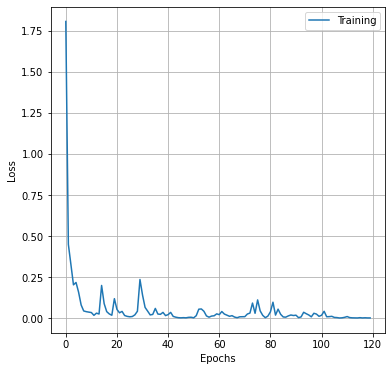

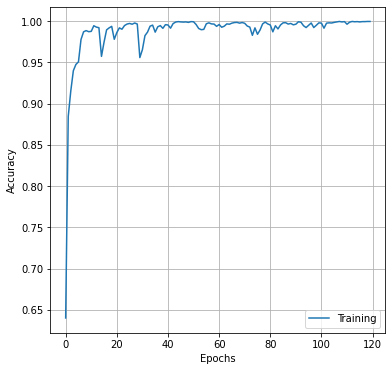

In [ ]:
plt.figure(figsize=(6,6))
plt.grid()
plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training','Validation'], loc='upper right')
plt.savefig(f'{loc_1}figure/{ratio_per}/{dataset}/{loc_2}loss_curve{dataset}.png')
# plt.show()

plt.figure(figsize=(6,6))
# plt.ylim(0,1.1)
plt.grid()
plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_acc'])
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Training','Validation'], loc='lower right')
plt.savefig(f'{loc_1}figure/{ratio_per}/{dataset}/{loc_2}acc_curve{dataset}.png')
# plt.show()

In [ ]:
import os.path

if os.path.isfile("/content/drive/MyDrive/Colab Notebooks/Paper 05/saved_model/default_model.hdf5") is False:
    model.save("/content/drive/MyDrive/Colab Notebooks/Paper 05/saved_model/default_model.hdf5")

# Validation

In [ ]:
# load best weights
model.load_weights("/content/drive/MyDrive/Colab Notebooks/Paper 05/saved_model/default_model.hdf5")
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [ ]:
Xtest = Xtest.reshape(-1, windowSize, windowSize, K, 1)
Xtest.shape

(48717, 25, 25, 5, 1)

In [ ]:
Y_pred_test = model.predict(Xtest)
y_pred_test = np.argmax(Y_pred_test, axis=1)

classification = classification_report(np.argmax(ytest, axis=1), y_pred_test)
print(classification)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1808
           1       1.00      1.00      1.00      3354
           2       1.00      1.00      1.00      1779
           3       0.99      1.00      1.00      1255
           4       1.00      1.00      1.00      2410
           5       1.00      1.00      1.00      3563
           6       1.00      1.00      1.00      3221
           7       1.00      1.00      1.00     10144
           8       1.00      1.00      1.00      5583
           9       1.00      1.00      1.00      2950
          10       1.00      0.99      1.00       961
          11       1.00      1.00      1.00      1734
          12       1.00      1.00      1.00       825
          13       1.00      1.00      1.00       963
          14       1.00      1.00      1.00      6541
          15       1.00      1.00      1.00      1626

    accuracy                           1.00     48717
   macro avg       1.00   

In [ ]:
def AA_andEachClassAccuracy(confusion_matrix):
    counter = confusion_matrix.shape[0]
    list_diag = np.diag(confusion_matrix)
    list_raw_sum = np.sum(confusion_matrix, axis=1)
    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
    average_acc = np.mean(each_acc)
    return each_acc, average_acc

In [ ]:
def reports (X_test,y_test,name,cm_img_loc):
    Y_pred = model.predict(X_test)
    y_pred = np.argmax(Y_pred, axis=1)
    if name == 'IP':
        target_names = ['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn'
                        ,'Grass-pasture', 'Grass-trees', 'Grass-pasture-mowed',
                        'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill',
                        'Soybean-clean', 'Wheat', 'Woods', 'Buildings-Grass-Trees-Drives',
                        'Stone-Steel-Towers']
    elif name == 'SA':
        target_names = ['Brocoli_green_weeds_1','Brocoli_green_weeds_2','Fallow','Fallow_rough_plow','Fallow_smooth',
                        'Stubble','Celery','Grapes_untrained','Soil_vinyard_develop','Corn_senesced_green_weeds',
                        'Lettuce_romaine_4wk','Lettuce_romaine_5wk','Lettuce_romaine_6wk','Lettuce_romaine_7wk',
                        'Vinyard_untrained','Vinyard_vertical_trellis']
    elif name == 'PU':
        target_names = ['Asphalt','Meadows','Gravel','Trees', 'Painted metal sheets','Bare Soil','Bitumen',
                        'Self-Blocking Bricks','Shadows']
    elif name == 'BW':
        target_names = ['water','hippo grass', 'floodplain grasses 1', 'floodplain grasses 2', 'reeds1',
                        'riparian', 'firescar2', 'island interior', 'acacia woodlands', 'acacia shrublands',
                        'acacia grasslands', 'short mopane', 'mixed mopane', 'exposed soils']

    classification = classification_report(np.argmax(y_test, axis=1),y_pred, target_names=target_names)
    oa = accuracy_score(np.argmax(y_test, axis=1),y_pred)
    confusion = confusion_matrix(np.argmax(y_test, axis=1),y_pred)
    each_acc, aa = AA_andEachClassAccuracy(confusion)
    kappa = cohen_kappa_score(np.argmax(y_test, axis=1),y_pred)
    score = model.evaluate(X_test, y_test)
    Test_accuracy = score*100

    # CLasswise accuracy measure --------------->
    row_col = [f"C{i}" for i in range(1,confusion.shape[0]+1)]
    cm_pd = pd.DataFrame(confusion, columns = row_col, index = row_col)

    cm_mid = confusion.astype('float') / confusion.sum(axis=1)[:, np.newaxis]
    CA = cm_mid.diagonal()
    CA_ = pd.DataFrame(CA, columns = ['C.A'],index = row_col)

    cm_pd = pd.concat([cm_pd,CA_], axis = 1)


    # Confusion matrix visualize ------------------->
    df_cm = pd.DataFrame(confusion, columns=np.unique(target_names), index = np.unique(target_names))
    df_cm.index.name = 'Actual'
    df_cm.columns.name = 'Predicted'
    plt.figure(figsize = (16,10))
    sn.set(font_scale=1.4)#for label size
    sn.heatmap(df_cm, cmap="PuBu", annot=True,annot_kws={"size": 16}, fmt='d')

    plt.savefig(cm_img_loc, bbox_inches='tight', dpi=300)
    plt.close()

    return classification, cm_pd, Test_accuracy, oa*100, aa*100, kappa*100

In [ ]:
file_name = f"{loc_1}reports/{ratio_per}/{dataset}/{loc_2}classification_report{dataset}.txt"
file_name2 = f"{loc_1}reports/{ratio_per}/{dataset}/{loc_2}classwise_accuracy{dataset}.csv"
file_name3 = f"{loc_1}figure/{ratio_per}/{dataset}/{loc_2}CM_img{dataset}.png"

classification, confusion, Test_accuracy, oa, aa, kappa = reports(Xtest,ytest,dataset,file_name3)
# print(classification)
classification = str(classification)
# confusion = str(confusion)

confusion.to_csv(file_name2)

with open(file_name, 'w') as x_file:
    x_file.write('{} Test accuracy (%)'.format(Test_accuracy))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{} Kappa accuracy (%)'.format(kappa))
    x_file.write('\n')
    x_file.write('{} Overall accuracy (%)'.format(oa))
    x_file.write('\n')
    x_file.write('{} Average accuracy (%)'.format(aa))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{}'.format(classification))
    # x_file.write('\n\nConfusion matrix:\n')
    # x_file.write('{}'.format(confusion))




1523/1523 [==============================] - 7s 4ms/step - loss: 0.0027 - accuracy: 0.9992


In [ ]:
def Patch(data,height_index,width_index):
    height_slice = slice(height_index, height_index+PATCH_SIZE)
    width_slice = slice(width_index, width_index+PATCH_SIZE)
    patch = data[height_slice, width_slice, :]

    return patch

In [ ]:
# load the original image
X, y = loadData(dataset)

In [ ]:
height = y.shape[0]
width = y.shape[1]
PATCH_SIZE = windowSize

In [ ]:
K = X.shape[2]
X,pca = applySPCA(X, numComponents=K)
K = 10 if dataset == 'IP' else 5
X = MIFS(X,y,K)
X.shape

In [ ]:
X = padWithZeros(X, PATCH_SIZE//2)

In [ ]:
# calculate the predicted image
outputs = np.zeros((height,width))
for i in range(height):
    for j in range(width):
        target = int(y[i,j])
        if target == 0 :
            continue
        else :
            image_patch=Patch(X,i,j)
            X_test_image = image_patch.reshape(1,image_patch.shape[0],image_patch.shape[1], image_patch.shape[2], 1).astype('float32')
            prediction = (model.predict(X_test_image))
            prediction = np.argmax(prediction, axis=1)
            outputs[i][j] = prediction+1

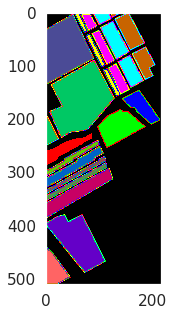

In [ ]:
ground_truth = spectral.imshow(classes = y,figsize =(5,5))

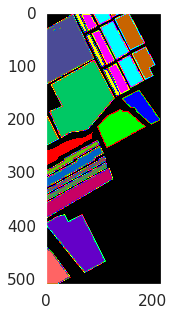

In [ ]:
predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(5,5))

In [ ]:
Cmap_loc = f"{loc_1}figure/{ratio_per}/{dataset}/{loc_2}classificaiton_map{dataset}.png"
spectral.save_rgb(Cmap_loc, outputs.astype(int), colors=spectral.spy_colors)

spectral.save_rgb(str(dataset)+"_ground_truth.jpg", y, colors=spectral.spy_colors)